In [3]:
!pip install scikit-image
!pip install opencv-python

In [4]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
from PIL import Image, ImageEnhance
from os import listdir
import imghdr
from skimage.transform import rotate, AffineTransform, warp
from skimage import filters
from torchvision import transforms
import cv2
import scipy
import random

In [ ]:
rmdir './Data_full/.ipynb_checkpoints'

In [6]:
# Feature: Get proportion of hand in the image
#Load Data
# return array of images
def loadImages(path):
    imagesList = listdir(path)
    imgs = []
    labels = []
    for image in imagesList:
      if imghdr.what(path + image) == 'png':
        if (image[len(image) - 13] == '1' and image[6].isalpha()): # only add 5 of each image, only add alphabetical values
          img = Image.open(path + image)
          imgs.append(img)
          labels.append(image[6]) # assumes that filename structure is 'handx_[label]_....'
    return imgs, labels

# Convert png img array to array np arrays
def ImagesToArray(imgs):
  imgs_array = []
  for img in imgs:
    img_array = np.array(img)
    imgs_array.append(img_array)
  return imgs_array

def HandToBack(imgs):
  features = [0] * imgs.shape[0]
  for i in range(imgs.shape[0]):
    img = imgs[i]
    total_pixels = img.shape[0] * img.shape[1]
    hand_pixels = 0
    # mean = np.mean(img)
    # std = np.std(img)
    # black_pixel_val = (0 - mean) / std
    img = np.reshape(img, (1, img.shape[0] * img.shape[1], 3))
    for j in range (img.shape[1]):
      if img[0][j][0] != 0 and img[0][j][1] != 0 and img[0][j][2] != 0:
        hand_pixels += 1
    features[i] =  hand_pixels / total_pixels

  return features
  
# Reshape Images   
def reshape_features(x):
  reshaped_array = np.zeros((len(x), 600, 600, 3))
  for i, img in enumerate(x):
    x_pad_width = (600 - img.shape[0])//2
    y_pad_width = (600 - img.shape[1])//2
    reshaped_array[i,:,:,:] = np.pad(img, ((x_pad_width, x_pad_width + (img.shape[0])%2), (y_pad_width, y_pad_width+(img.shape[1]%2)), (0,0)), constant_values=img[0][0][0])
  return reshaped_array.astype('uint8')


def Scale_features(imgs):
  scaled_images = np.zeros((len(imgs), 600, 600, 3))
  for i, img in enumerate(imgs):
    # ratio = random.randrange(.2, .5, .1)
    ratio = random.choice([0.1, 0.2, 0.3, 0.4])
    x = int(ratio * 600 / 2)
    scaled = img[x:600-x, x:600-x]
    # scaled = cv2.imread(scaled)
    res = cv2.resize(scaled, dsize=(600, 600), interpolation=cv2.INTER_CUBIC)
    scaled_images[i] = res
  return scaled_images.astype('uint8')
    # final.save('./Crop/img_' + str(i) + '_scale.png')

def Rotate30_features(imgs): 
  rot30_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  for i, img in enumerate(imgs): 
    rand_dir = random.choice([-1, 1])
    new_img = rotate(img, rand_dir * 30) 
    rot30_imgs[i, :] = new_img
  return rot30_imgs

def VerticalFlip_features(imgs): 
  flip_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  for i, img in enumerate(imgs): 
    new_img = np.fliplr(img)
    flip_imgs[i, :, :, :] = new_img
  return flip_imgs.astype('uint8')

def Translation_features(imgs): 
  trans_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  for i, img in enumerate(imgs): 
    rand_x = random.randrange(-150, 150, 50)
    rand_y = random.randrange(-150, 150, 50)
    transform = AffineTransform(translation=(rand_x,rand_y))
    new_img = warp(img,transform, mode="constant")  
    trans_imgs[i, :] = new_img
  return trans_imgs

def getFeaturesHandToBack(imgs_array_before, i):
  reshaped_imgs = reshape_features(imgs_array_before)
  scaled_imgs_new = Scale_features(reshaped_imgs)
  translated_imgs_new = Translation_features(reshaped_imgs)
  flipped_imgs_new = VerticalFlip_features(reshaped_imgs)
  rotated30_imgs_new = Rotate30_features(reshaped_imgs)

  fig, ax = plt.subplots(1, 5, figsize=(15,10))
  ax[0].imshow(reshaped_imgs[0]) # Step 0
  ax[1].imshow(scaled_imgs_new[0]) # Step 1
  ax[2].imshow(translated_imgs_new[0]) # Step 2
  ax[3].imshow(flipped_imgs_new[0]) # Step 3
  ax[4].imshow(rotated30_imgs_new[0]) # Step 4

  features_orig = HandToBack(reshaped_imgs) #same for orig, blurred, brightened, darkened
  features_scaled = HandToBack(scaled_imgs_new) # for scaled
  features_translated = HandToBack(translated_imgs_new) # for translated
  features_flipped = HandToBack(flipped_imgs_new) # for flipped
  features_rotated30 = HandToBack(rotated30_imgs_new) # for rotated30

  features_hand_to_back_temp = np.concatenate((features_orig, features_orig, features_scaled, features_translated, features_flipped, features_rotated30), 0)
  print(features_hand_to_back_temp.shape)
  # np.save('../FeaturesHandToBack/features_hand_to_back' + str(i) + '.npy', features_hand_to_back_temp)
  return features_hand_to_back_temp

# load png_images
path = "../Data_full/"
# images in an array named imgs
imgs, labels = loadImages(path)
print(len(imgs))
# Step 1 convert png_images to np arrays
imgs_array_before = ImagesToArray(imgs)

130


(390,)
(390,)
(780,)


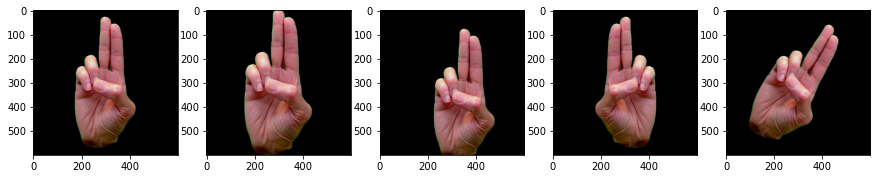

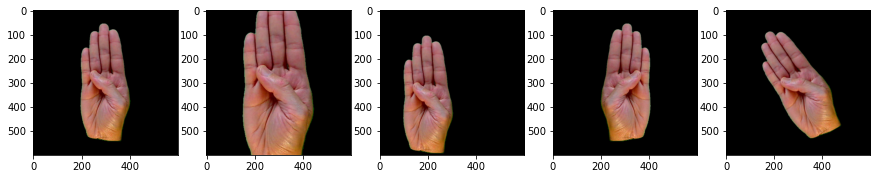

In [8]:
features_hand_to_back = np.empty(0)
n = int(130/65)
for i in range(n):
  features_hand_to_back_temp = getFeaturesHandToBack(imgs_array_before[i * 65:(i + 1) * 65], i)
  features_hand_to_back = np.concatenate((features_hand_to_back, features_hand_to_back_temp), 0)

print(features_hand_to_back.shape)
np.save('../FeaturesHandToBack/features_hand_to_back.npy', features_hand_to_back)